# 1. Train a convolutional neural network model

## 1.1 Data Loading and Transformation

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '~/Desktop/Applied Machine Learning/Assignment 4/img'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1.2 - 1.3 Deﬁne loss function and optimizer, and Train Resnet18 from scratch

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        if (epoch+1) % 10 == 0:
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                #epoch_loss = running_loss / dataset_sizes[phase]
                #epoch_acc = running_corrects.double() / dataset_sizes[phase]
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                #epoch_loss = running_loss / dataset_sizes[phase]
                #epoch_acc = running_corrects.double() / dataset_sizes[phase]
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            if (epoch+1) % 10 == 0:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc

In [4]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001, betas=(0.9, 0.99))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft1,train_loss1,val_loss1, train_acc1, val_acc1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 10/50
----------
train Loss: 0.6644 Acc: 0.6140
val Loss: 0.6827 Acc: 0.5500
Epoch 20/50
----------
train Loss: 0.6329 Acc: 0.6660
val Loss: 0.7018 Acc: 0.5300
Epoch 30/50
----------
train Loss: 0.6489 Acc: 0.6200
val Loss: 0.6999 Acc: 0.5300
Epoch 40/50
----------
train Loss: 0.6668 Acc: 0.6080
val Loss: 0.7026 Acc: 0.5400
Epoch 50/50
----------
train Loss: 0.6282 Acc: 0.6440
val Loss: 0.6991 Acc: 0.5100
Training complete in 53m 2s
Best val Acc: 0.600000


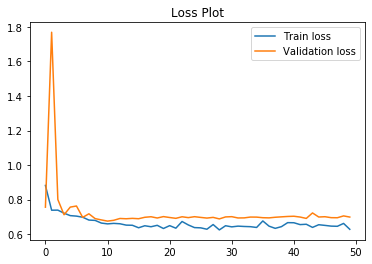

In [5]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot( train_loss1, label='Train loss')
ax.plot( val_loss1, label='Validation loss')
plt.title('Loss Plot')
ax.legend()
plt.show()

In [6]:
label = []
predict = []
with torch.no_grad():
    for i, (images, classes) in enumerate(dataloaders['val']):
        images = images.to(device)
        classes = classes.to(device)
        outputs = model_ft1(images)
        _, predicted = torch.max(outputs, 1)
        for c, p in zip(classes.view(-1), predicted.view(-1)):
            label.append(c.numpy())
            predict.append(p.numpy())
        
        

Text(0.5, 1, 'Confusion Matrix')

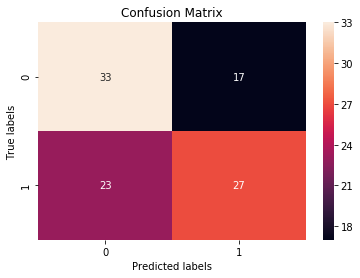

In [7]:
from sklearn import metrics
import seaborn as sns
confusion = metrics.confusion_matrix(label, predict)
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [8]:
tp = confusion[0][0]
fn = confusion[0][1]
fp = confusion[1][0]
tn = confusion[1][1]

In [9]:
accuracy = (tp+tn)/(tp+fn+fp+tn)
accuracy

0.6

In [10]:
precision = tp/(tp+fp)
precision

0.5892857142857143

In [11]:
recall = tp/(tp+fn)
recall

0.66

In [12]:
F1score = 2*precision*recall/(precision+recall)
F1score

0.6226415094339622

## 1.4 Transfer learning: pre-trained Resnet18 on ImageNet

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001, betas=(0.9, 0.99))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft2, train_loss2,val_loss2, train_acc2, val_acc2= train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 10/20
----------
train Loss: 0.6825 Acc: 0.5720
val Loss: 0.6598 Acc: 0.6100
Epoch 20/20
----------
train Loss: 0.6497 Acc: 0.6020
val Loss: 0.6859 Acc: 0.6000
Training complete in 20m 59s
Best val Acc: 0.610000


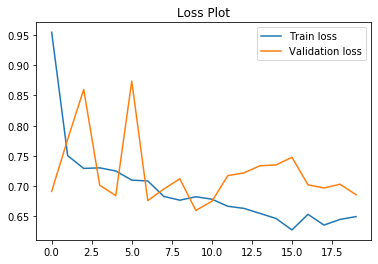

In [14]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot( train_loss2, label='Train loss')
ax.plot( val_loss2, label='Validation loss')
plt.title('Loss Plot')
ax.legend()
plt.show()

In [15]:
label1 = []
predict1 = []
with torch.no_grad():
    for i, (images, classes) in enumerate(dataloaders['val']):
        images = images.to(device)
        classes = classes.to(device)
        outputs = model_ft2(images)
        _, predicted = torch.max(outputs, 1)
        for c, p in zip(classes.view(-1), predicted.view(-1)):
            label1.append(c.numpy())
            predict1.append(p.numpy())

Text(0.5, 1, 'Confusion Matrix')

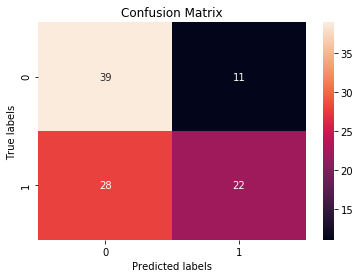

In [16]:
from sklearn import metrics
import seaborn as sns
confusion1 = metrics.confusion_matrix(label1, predict1)
ax= plt.subplot()
sns.heatmap(confusion1, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [17]:
tp = confusion1[0][0]
fn = confusion1[0][1]
fp = confusion1[1][0]
tn = confusion1[1][1]

In [18]:
accuracy = (tp+tn)/(tp+fn+fp+tn)
accuracy

0.61

In [19]:
precision = tp/(tp+fp)
precision

0.582089552238806

In [20]:
recall = tp/(tp+fn)
recall

0.78

In [21]:
F1score = 2*precision*recall/(precision+recall)
F1score

0.6666666666666667

Compared the result between pretained and non-pretained, it can be found that the value of accuracy score and F1 score pretained model are higher than non-pretained model. Moreover, pretained model is faster for training than non-pretained model as well. 